In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-dataset/README.dataset.txt
/kaggle/input/flowers-dataset/README.roboflow.txt
/kaggle/input/flowers-dataset/valid/dandelion/33857574164_b0b724b567_n_jpg.rf.7b99dd4c5c099777768ab5129a29d570.jpg
/kaggle/input/flowers-dataset/valid/dandelion/6495802659_98b57e0cca_m_jpg.rf.1095124909c35debcea108ed07d44eb9.jpg
/kaggle/input/flowers-dataset/valid/dandelion/15378782362_4161b23af7_m_jpg.rf.5660236373de659a56b40ae54cc25e61.jpg
/kaggle/input/flowers-dataset/valid/dandelion/5607983792_f8b8766ff7_jpg.rf.011e016018d8373dccd60fe8440e0992.jpg
/kaggle/input/flowers-dataset/valid/dandelion/3451646670_3eff7094b7_n_jpg.rf.392c7bc357ebcc2a645e68178f2cec0e.jpg
/kaggle/input/flowers-dataset/valid/dandelion/3696596109_4c4419128a_m_jpg.rf.003cb976f4403bbf6aae622d629d9841.jpg
/kaggle/input/flowers-dataset/valid/dandelion/2477231067_3aecef1bf8_n_jpg.rf.21cb5619be696e0ad2514e94537b766c.jpg
/kaggle/input/flowers-dataset/valid/dandelion/2628514700_b6d5325797_n_jpg.rf.4248eeeba8c3b6c1fce3721c83

# Mounting the Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alsaniipe/flowers-dataset")

print("Path to dataset files:", path)

# Importing Libraries

In [2]:
import os
import torch
import timm
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from timm.data import resolve_model_data_config


print("Section runs successfully")

Section runs successfully


# Setting Config and Hyper Parameters

In [3]:
CFG = {
    # give corresponding model name from model finder given at the end of the notebook
    'model_name': 'davit_base.msft_in1k',
    # give your corresponding batch size
    'batch_size': 32,
    # give corresponding epoch number
    'epochs': 3,
    # give appropriate learning rate
    'learning_rate': 1e-3,
    # num of workers from 0-4
    'num_workers': 2,
    # seed for reproducibility
    'seed': 42,
    # adjust your training directory
    'train_directory': '/kaggle/input/flowers-dataset/train',
    # adjust your validation directory
    'val_directory': '/kaggle/input/flowers-dataset/valid',
    # adjust your test directory
    'test_directory': '/kaggle/input/flowers-dataset/test',
    'save_path': './model_checkpoints',
    'results_dir': './results'
}
os.makedirs(CFG['save_path'], exist_ok=True)
os.makedirs(CFG['results_dir'], exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Section runs successfully")

Using device: cuda
Section runs successfully


# Defining Seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG['seed'])

print("Section runs successfully")

Section runs successfully


# Checking Model Config

In [5]:
data_config = resolve_model_data_config(CFG['model_name'])
print("\n",data_config)

print("Section runs successfully")


 {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
Section runs successfully


# Model and Data Transformations

In [7]:
from timm.data import resolve_model_data_config
from torchvision import transforms

# Model + Data Transforms
# ----------------------------
def get_model(model_name, num_classes, device=torch.device("cpu")):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)



def get_data_transforms(model, is_training=False):
    data_config = resolve_model_data_config(model)
    #print("\n",data_config)
    input_size = data_config.get('input_size', (3, 224, 224))[1:]
    mean = data_config.get('mean', (0.485, 0.456, 0.406))
    std = data_config.get('std', (0.229, 0.224, 0.225))

    print(f"\n[INFO] Creating {'training' if is_training else 'validation/testing'} transform")
    print(f"[INFO] Using input size: {input_size}, mean: {mean}, std: {std}")

    transform_list = []
    if is_training:
        transform_list += [
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandAugment(num_ops=2, magnitude=9)
        ]
    else:
        transform_list += [
            transforms.Resize([int(x / 0.95) for x in input_size]),
            transforms.CenterCrop(input_size)
        ]

    transform_list += [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]

    return transforms.Compose(transform_list)


print("Section runs successfully")

Section runs successfully


# Data Loaders

In [8]:
from torchvision import datasets
from torch.utils.data import DataLoader

# ----------------------------
# Data Loaders
# ----------------------------

def prepare_dataloader(directory, model, batch_size, is_training):
    transform = get_data_transforms(model, is_training=is_training)
    dataset = datasets.ImageFolder(directory, transform=transform)

    if is_training:
        # Ensures reproducible shuffling in training
        generator = torch.Generator()
        generator.manual_seed(CFG['seed'])
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=CFG['num_workers'],
            pin_memory=True,
            generator=generator
        )
    else:
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=CFG['num_workers'],
            pin_memory=True
        )

    return loader, dataset.classes


def get_dataloaders():
    # Temporary model for transform config
    temp_model = get_model(CFG['model_name'], num_classes=1, device=device)
    
    # Load training data once to get class names
    train_loader, class_names = prepare_dataloader(
        CFG['train_directory'], temp_model, CFG['batch_size'], is_training=True
    )

    # Redefine model with correct num_classes
    num_classes = len(class_names)
    model = get_model(CFG['model_name'], num_classes, device)

    # Use the final model for val/test dataloaders
    val_loader, _ = prepare_dataloader(
        CFG['val_directory'], model, CFG['batch_size'], is_training=False)
    test_loader, _ = prepare_dataloader(
        CFG['test_directory'], model, CFG['batch_size'], is_training=False)

    return train_loader, val_loader, test_loader, class_names


print("Section runs successfully")

Section runs successfully


# Training and Validation Loop

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


print("Section runs successfully")

Section runs successfully


# Run Training Loop

In [22]:
import pandas as pd

def run_training():
    train_loader, val_loader, test_loader, class_names = get_dataloaders()
    model = get_model(CFG['model_name'], len(class_names), device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG['learning_rate'])

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, CFG['epochs'] + 1):
        print(f"\nEpoch {epoch}/{CFG['epochs']}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        # Save model checkpoint
        save_path = os.path.join(CFG['save_path'], f"model_epoch_{epoch}__{CFG['model_name']}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, save_path)
        print(f"Model checkpoint saved at: {save_path}")

        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # Plot and save metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save training log to Excel
    metrics_df = pd.DataFrame({
        'Epoch': list(range(1, CFG['epochs'] + 1)),
        'Train Loss': train_losses,
        'Val Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Val Accuracy': val_accuracies
    })

    log_path = os.path.join(CFG['results_dir'], f"epoch_metrics_{CFG['model_name']}.xlsx")
    metrics_df.to_excel(log_path, index=False)
    print(f"[✔] Training log saved to: {log_path}")


# Plot Training Metrics

In [12]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    # Loss Plot
    plt.figure()
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')  # blue circle markers
    plt.plot(epochs, val_losses, 'rs-', label='Val Loss')      # red square markers
    plt.xticks(epochs)  # Force integer ticks on x-axis
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(CFG['results_dir'], f"loss_curve_{CFG['model_name']}.png"))
    plt.show()
    plt.close()

    # Accuracy Plot
    plt.figure()
    plt.plot(epochs, train_accuracies, 'g^-', label='Train Acc')  # green triangle markers
    plt.plot(epochs, val_accuracies, 'md-', label='Val Acc')      # magenta diamond markers
    plt.xticks(epochs)  # Force integer ticks on x-axis
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(CFG['results_dir'], f"accuracy_curve_{CFG['model_name']}.png"))
    plt.show()
    plt.close()



print("Section runs successfully")

Section runs successfully


# Load Model For Evaluation

In [13]:
def load_model(model_name, num_classes, epoch, path):
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    checkpoint = torch.load(f"{path}/model_epoch_{epoch}__{CFG['model_name']}.pt", map_location='cpu',weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])  # ✅ only load the weights
    model.eval()
    return model


print("Section runs successfully")

Section runs successfully


# Classification Report and Confusion Matrix

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings  # Just use warnings
from sklearn.metrics import classification_report

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UserWarning)  # Filter UserWarnings in general

def plot_confusion_matrix(conf_matrix, class_names, model_name, save_dir='./results'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"confusion_matrix_{model_name}.png")
    plt.savefig(save_path)
    print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()
    plt.close()


def evaluate_and_save(model, dataloader, class_names, save_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []
   
    model.to(device)

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    
    # Using zero_division=1 to handle undefined metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=1)

    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n Test Accuracy: {acc:.4f}\n")
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))
    print("Confusion Matrix:\n", conf_matrix)

    # Plot Confusion Matrix
    plot_confusion_matrix(conf_matrix, class_names, CFG['model_name'], save_dir)


    # Save to Excel
    os.makedirs(save_dir, exist_ok=True)
    report_df = pd.DataFrame(report).transpose()
    conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    with pd.ExcelWriter(f"{save_dir}/Test_Metrics_{CFG['model_name']}.xlsx") as writer:
        report_df.to_excel(writer, sheet_name='Classification_Report')
        conf_df.to_excel(writer, sheet_name='Confusion_Matrix')

    print(f"\nResults saved to: {save_dir}/test_metrics.xlsx")

    return acc, report_df, conf_df
    

print("Section runs successfully")


Section runs successfully


# Start Training


[INFO] Creating training transform
[INFO] Using input size: (224, 224), mean: (0.485, 0.456, 0.406), std: (0.229, 0.224, 0.225)

[INFO] Creating validation/testing transform
[INFO] Using input size: (224, 224), mean: (0.485, 0.456, 0.406), std: (0.229, 0.224, 0.225)

[INFO] Creating validation/testing transform
[INFO] Using input size: (224, 224), mean: (0.485, 0.456, 0.406), std: (0.229, 0.224, 0.225)

Epoch 1/3


Validation: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


Train Loss: 0.3939, Train Acc: 0.8173
Val   Loss: 0.1701, Val   Acc: 0.9368
Model checkpoint saved at: ./model_checkpoints/model_epoch_1__davit_base.msft_in1k.pt

Epoch 2/3


Validation: 100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


Train Loss: 0.2553, Train Acc: 0.8886
Val   Loss: 0.1669, Val   Acc: 0.9368
Model checkpoint saved at: ./model_checkpoints/model_epoch_2__davit_base.msft_in1k.pt

Epoch 3/3


Validation: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]


Train Loss: 0.2454, Train Acc: 0.9027
Val   Loss: 0.1686, Val   Acc: 0.9231
Model checkpoint saved at: ./model_checkpoints/model_epoch_3__davit_base.msft_in1k.pt


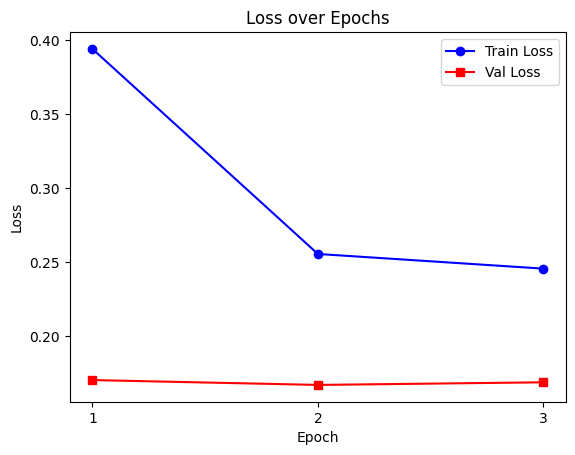

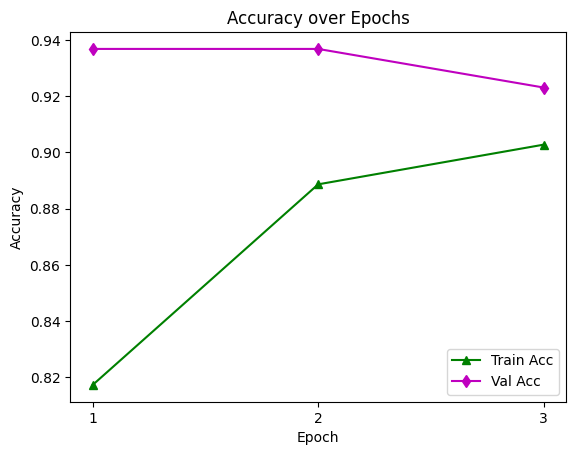

[✔] Training log saved to: ./results/epoch_metrics_davit_base.msft_in1k.xlsx


In [23]:
run_training()


# Model Evaluation


[INFO] Creating training transform
[INFO] Using input size: (224, 224), mean: (0.485, 0.456, 0.406), std: (0.229, 0.224, 0.225)

[INFO] Creating validation/testing transform
[INFO] Using input size: (224, 224), mean: (0.485, 0.456, 0.406), std: (0.229, 0.224, 0.225)

[INFO] Creating validation/testing transform
[INFO] Using input size: (224, 224), mean: (0.485, 0.456, 0.406), std: (0.229, 0.224, 0.225)

 Test Accuracy: 0.9066

Classification Report:
               precision    recall  f1-score   support

       daisy       0.86      0.94      0.89        77
   dandelion       0.95      0.89      0.92       105

    accuracy                           0.91       182
   macro avg       0.90      0.91      0.91       182
weighted avg       0.91      0.91      0.91       182

Confusion Matrix:
 [[72  5]
 [12 93]]
Confusion matrix saved to: ./results/confusion_matrix_davit_base.msft_in1k.png


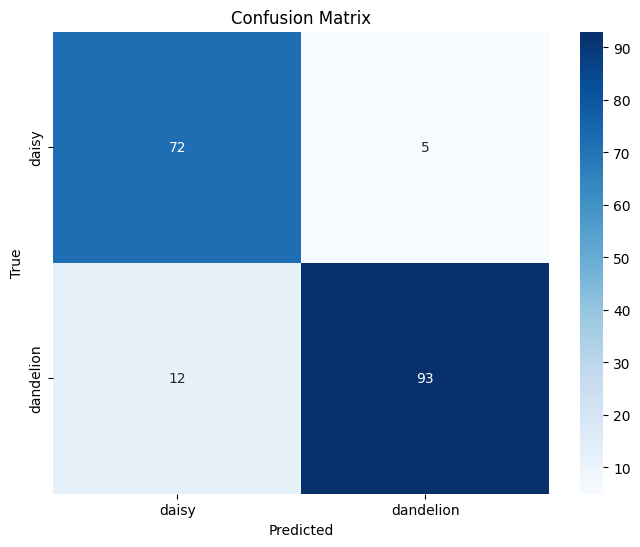


Results saved to: ./results/test_metrics.xlsx
Testing Accuracy of davit_base.msft_in1k is:  0.9065934065934066
Section runs successfully


In [24]:
# Evaluation

# Set Which Epoch's model for testing
epoch_number=3

train_loader, val_loader, test_loader, class_names = get_dataloaders()

model = load_model(CFG['model_name'], len(class_names), epoch=epoch_number, path=CFG['save_path'])

acc, report_df, conf_df = evaluate_and_save(model, test_loader, class_names, save_dir='./results')

print(f"Testing Accuracy of {CFG['model_name']} is: ", acc)

print("Section runs successfully")


# Model Finder

In [3]:
avail_pretrained_models = timm.list_models('*davit*',pretrained=True)
print(len(avail_pretrained_models))
avail_pretrained_models

5


['davit_base.msft_in1k',
 'davit_base_fl.msft_florence2',
 'davit_huge_fl.msft_florence2',
 'davit_small.msft_in1k',
 'davit_tiny.msft_in1k']